In [1]:
import numpy as np
import control as ct
import control.optimal as obc
import matplotlib.pyplot as plt

def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    l = params.get('wheelbase', 3.)         # vehicle wheelbase
    phimax = params.get('maxsteer', 0.5)    # max steering angle (rad)

    # Saturate the steering input
    phi = np.clip(u[1], -phimax, phimax)

    # Return the derivative of the state
    return np.array([
        np.cos(x[2]) * u[0],            # xdot = cos(theta) v
        np.sin(x[2]) * u[0],            # ydot = sin(theta) v
        (u[0] / l) * np.tan(phi)        # thdot = v/l tan(phi)
    ])

def vehicle_output(t, x, u, params):
    return x                            # return x, y, theta (full state)

# Define the vehicle steering dynamics as an input/output system
vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=('v', 'phi'), outputs=('x', 'y', 'theta'))

We consider an optimal control problem that consists of “changing lanes” by moving from the point x = 0 m, y = -2 m, \theta = 0 to the point x = 100 m, y = 2 m, \theta = 0) over a period of 10 seconds and with a with a starting and ending velocity of 10 m/s:

In [2]:
x0 = np.array([0., -2., 0.]); u0 = np.array([10., 0.])
xf = np.array([100., 2., 0.]); uf = np.array([10., 0.])
Tf = 10

To set up the optimal control problem we design a cost function that penalizes the state and input using quadratic cost functions:

In [3]:
Q = np.diag([0, 0, 0.1])          # don't turn too sharply
R = np.diag([1, 1])               # keep inputs small
P = np.diag([1000, 1000, 1000])   # get close to final point
traj_cost = obc.quadratic_cost(vehicle, Q, R, x0=xf, u0=uf)
term_cost = obc.quadratic_cost(vehicle, P, 0, x0=xf)

We also constraint the maximum turning rate to 0.1 radians (about 6 degees) and constrain the velocity to be in the range of 9 m/s to 11 m/s:

In [4]:
constraints = [ obc.input_range_constraint(vehicle, [8, -0.1], [12, 0.1]) ]

Finally, we solve for the optimal inputs:

In [5]:
timepts = np.linspace(0, Tf, 10, endpoint=True)
result = obc.solve_ocp(
    vehicle, timepts, x0, traj_cost, constraints,
    terminal_cost=term_cost, initial_guess=u0)

Summary statistics:
* Cost function calls: 2000
* Constraint calls: 2091
* System simulations: 1
* Final cost: 0.0030294402797598975


Plotting the results:

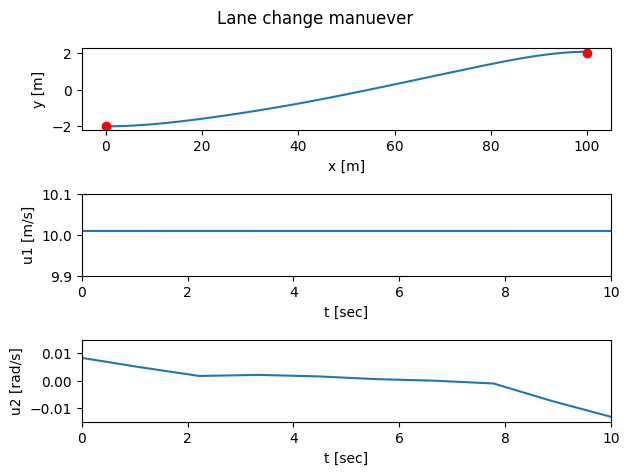

In [6]:
# Simulate the system dynamics (open loop)
resp = ct.input_output_response(
    vehicle, timepts, result.inputs, x0,
    t_eval=np.linspace(0, Tf, 100))
t, y, u = resp.time, resp.outputs, resp.inputs

plt.subplot(3, 1, 1)
plt.plot(y[0], y[1])
plt.plot(x0[0], x0[1], 'ro', xf[0], xf[1], 'ro')
plt.xlabel("x [m]")
plt.ylabel("y [m]")

plt.subplot(3, 1, 2)
plt.plot(t, u[0])
plt.axis([0, 10, 9.9, 10.1])
plt.xlabel("t [sec]")
plt.ylabel("u1 [m/s]")

plt.subplot(3, 1, 3)
plt.plot(t, u[1])
plt.axis([0, 10, -0.015, 0.015])
plt.xlabel("t [sec]")
plt.ylabel("u2 [rad/s]")

plt.suptitle("Lane change manuever")
plt.tight_layout()
plt.show()